## **Varied Stimuli Durations Tutorial**

Another key consideration in fMRI experiments is that the time each stimuli is present can vary for each stimuli. The base Neurodesign package allows the user to input one stimuli duration, which is then used for all stimuli, thus this modificaiton allows you to add custom stimuli_durations for each stimuli as either a value or a distribution.

* **`stimuli_durations`** `(list of int or dicts)`
    * A list of `stimuli_durations` corresponding to each stimulus (length of `stimuli_durations` must be the same as `n_stimuli`).
    * If not provided, `stimuli_durations` uses `stimuli_duration` (the previous class duration variable) for all stimuli.

* **`trial_max`** `(float)`
    * Refers to the max `stimuli_duration` provided in the list of `stimuli_durations`.
    * Used to calculate a maximum `n_tp` (timepoints), so the XConv calculation in the design can work for all varying ITIs and stimuli durations.


### **Example**

For the following example, we will provide a stimuli for each of four stimuli.

- For Stimuli 0, the stimuli duration is defined by a gaussian distribution, with standard deviation = 0.2, mean = 1.2, min = 0.5, max = 5.5

- For Stimuli 1, the stimuli duration is defined by fixed number 7.5

- For Stimuli 2, the stimuli duration is defined by fixed number 2

- For Stimuli 3, the stimuli duration is defined by a uniform distribution with min = 3.5, max = 3.5


** This can be written in code as follows:** 
```python
stimuli_durations = [{"model": "gaussian", "std": 0.2, "mean": 1.2, "min": 0.5, "max": 5.5}, 
                     7.5, 2, {"model": "uniform", "min": 3.5, "max": 4.5}]
```

**Note:** Since in these four distributions, the highest possible instance of a stimuli_duration is 7.5, **trial_max = 7.5**.

In [1]:
import numpy as np
import neurodesign
import matplotlib.pyplot as plt

In [2]:
import os
# Since Neurodesign uses multi-threading internally, limit the number of threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
stimuli_durations = [{"model": "gaussian", "std": 0.2, "mean": 1.2, "min": 0.5, "max": 5.5}, 
                     7.5, 2, {"model": "uniform", "min": 3.5, "max": 4.5}]
trial_max = 7.5

In [9]:
exp = neurodesign.Experiment(
    TR=2,                        # Repetition time (TR) of fMRI acquisition in seconds
    n_trials=20,                 # Number of trials (short toy example)
    P=[0.25, 0.25, 0.25, 0.25],           # Condition probabilities: Condition 2 is slightly overrepresented
    C=[[1,0, -1, 0],[1, 0, 0, -1], [0, 1, -1, 0],  [0, 1, 0,-1]],  # Contrasts: C1 vs C3, C1 vs C4
    n_stimuli=4,                 # Total number of stimulus conditions
    rho=0.3,                     # Temporal autocorrelation in fMRI noise
    stim_duration=1,            # Duration of each stimulus (in seconds)
    t_pre=1,                  # Pre-stimulus baseline (e.g., fixation)
    t_post=0.5,                   # Post-stimulus period (e.g., feedback)
    ITImodel="exponential",     # Inter-trial interval (ITI) sampling model
    ITImin=1,                   # Minimum ITI
    ITImax=4,                   # Maximum ITI
    ITImean=2.5,                # Mean ITI
    stimuli_durations=stimuli_durations,
    trial_max=trial_max,
)

In [10]:
population = neurodesign.Optimisation(
    experiment=exp,
    R=[1, 0, 0], # 100% blocked, 0% random, 0% msequence
    weights=[0, 0.5, 0.25, 0.25],  # Weights for Fe, Fd, confounding, and frequency
    preruncycles=10,               # Warm-up iterations
    cycles=100,                    # Main genetic algorithm iterations
    folder="./",                   # Output folder for results
    seed=100                       # Seed for reproducibility
)

population.optimise()             # Run the optimization

In [11]:
best_design = population.bestdesign  # The best subject from the final generation

print(f"Fd (detection efficiency): {best_design.Fd}")
print(f"Ff (estimation efficiency): {best_design.Ff}")
print(f"Fc (confounding): {best_design.Fc}")
print(f"Fe (stimulus frequency balance): {best_design.Fe}")

Fd (detection efficiency): 1.0035935666916187
Ff (estimation efficiency): 1.0
Fc (confounding): 0.6735395189003437
Fe (stimulus frequency balance): 0


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.09093612e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.06803349e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.44202483e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.61920904e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.99874631e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.11401419e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.32748713e-01  2.20928373e-02  0.00000000e+00]
 [ 0.00000000e+00  2.72223438e-01  2.64016603e-01  0.00000000e+00]
 [ 0.00000000e+00  6.56004696e-02  5.53879146e-01  0.00000000e+00]
 [ 0.00000000e+00 -3.66517185e-02  7.21839202e-01  2.71005447e-07]
 [ 0.00000000e+00 -7.03458276e-02  7.52814472e-01  3.28030151e-02]
 [ 0.00000000e+00 -6.86069336e-02  4.95258710e-01  3.05105941e-01]
 [ 0.00000000e+00 -5.20321018e-02  1.97810859e-01  6.05275048e-01]
 [ 0.00000000e+00 -3.32755120e-02  1.46678448e-02  5.45258252e

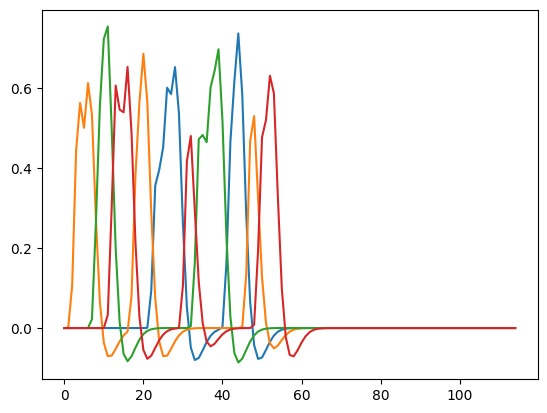

In [12]:
# Compute the convolved bestdesign matrix and evaluate design quality
best_design.designmatrix()
print(best_design.Xconv)
plt.plot(best_design.Xconv)

#### **Observations**
1. Notice that the peaks are now all of different size, this is because of the varied stimuli_durations. The higher the stimuli duration, the higher the peak displayed on the diagram.

2. We have provided no fixed ordering or conditional probabilities, so the ordering is random based on the probability distrubtion.

3. **There is a lot of empty space offset, why is this?** Since we give a range of stimuli_durations along with distributions, the model uses the maximum possible durations to calculate the timepoints, and then maps the real values onto the graph, ensuring any randomized mapping of timepoints will fit on the graph
    - An easy way to clean this is simply bounding the x-axis on the plot.